In [1]:
import pandas as pd
import numpy as np
from math import isnan

from sklearn.metrics import confusion_matrix as confmat
from sklearn.metrics import f1_score as f1
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
# from sklearn.metrics import plot_confusion_matrix as plot_confmat

# import re
# import string
import random
import importlib

# import nltk
# from nltk.corpus import stopwords
# from nltk.stem.porter import PorterStemmer
 
import torch
import preprocess
import dan
from ROC_Curve_Conf_Matrix import plot_confusion_matrix

import gensim
# load dataset and preprocess
# twt = pd.read_csv('train.csv')
twt = pd.read_csv('train.csv')
twt = twt.set_index('id')
# twt = twt.loc[twt.index < 20000,]
add = pd.read_csv('tweets_0_300.csv')
add = add.set_index('id')
twt.head()

print(twt['target'].value_counts()/len(twt['target']))
print(add['target'].value_counts()/len(add['target']))

# create text+ column which includes location
twt['text+'] = twt.apply(lambda x: x['text'] if pd.isna(x['location']) else  x['location'] + ' ' + x['text'], axis = 1) 

twt['text++'] = twt.apply(lambda x: x['text+'] if pd.isna(x['keyword']) else x['keyword'] + ' ' + x['text+'], axis = 1)
twt.loc[~twt['keyword'].isna(),]

0    0.57034
1    0.42966
Name: target, dtype: float64
0    1.0
Name: target, dtype: float64


,keyword,location,text,target,text+,text++
id,,,,,,
48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,Birmingham @bbcmtd Wholesale Markets ablaze ht...,ablaze Birmingham @bbcmtd Wholesale Markets ab...
49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,Est. September 2012 - Bristol We always try to...,ablaze Est. September 2012 - Bristol We always...
50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,AFRICA #AFRICANBAZE: Breaking news:Nigeria fla...,ablaze AFRICA #AFRICANBAZE: Breaking news:Nige...
52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,"Philadelphia, PA Crying out for more! Set me a...","ablaze Philadelphia, PA Crying out for more! S..."
53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,"London, UK On plus side LOOK AT THE SKY LAST N...","ablaze London, UK On plus side LOOK AT THE SKY..."
...,...,...,...,...,...,...
10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0,@jt_ruff23 @cameronhacker and I wrecked you both,wrecked @jt_ruff23 @cameronhacker and I wrecke...
10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,"Vancouver, Canada Three days off from work and...","wrecked Vancouver, Canada Three days off from ..."
10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,London #FX #forex #trading Cramer: Iger's 3 w...,wrecked London #FX #forex #trading Cramer: Ig...


## 0. Data Preprocessing

### 0.1 Data Cleaning

In [2]:
text = twt['text'].to_list()
prep_text = [preprocess.processing(i) for i in text]
print('{} tweets lowered, tokenized, alphanumerized, stop-stripped, and stemmed.'.format(len(prep_text)))  
twt['prepped'] = prep_text

7613 tweets lowered, tokenized, alphanumerized, stop-stripped, and stemmed.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
 4   text+     7613 non-null   object
 5   text++    7613 non-null   object
 6   prepped   7613 non-null   object
dtypes: int64(1), object(6)
memory usage: 475.8+ KB


### 0.2 Embedding

In [3]:
# load word2vec mapping the first time
word2vec = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)

In [4]:
importlib.reload(preprocess)
twt['vec'] = pd.Series([preprocess.tweet_vec(tweet, word2vec) for tweet in twt['prepped']], index = twt.index)

devtrain_idx = twt.loc[~twt['vec'].isna()].index.tolist()
random.shuffle(devtrain_idx)

train_p = 0.70
train_idx = devtrain_idx[:round(train_p*len(devtrain_idx))]
dev_idx = devtrain_idx[round(train_p*len(devtrain_idx)):]

train = [(vec, targ) for targ, vec in  zip(twt['target'][train_idx], twt['vec'][train_idx])]
dev = [(vec, targ) for targ, vec in  zip(twt['target'][dev_idx], twt['vec'][dev_idx])]

## 1. NN construction

In [18]:
import importlib
importlib.reload(dan)
net = dan.Net(hiddenDim = 52)
net.train(train, dev)

[1,     1] loss: 0.691	Dev FI: 0.002
[1,     2] loss: 0.680	Dev FI: 0.008
[2,     1] loss: 0.669	Dev FI: 0.109
[2,     2] loss: 0.658	Dev FI: 0.286
[3,     1] loss: 0.642	Dev FI: 0.496
[3,     2] loss: 0.627	Dev FI: 0.632
[4,     1] loss: 0.605	Dev FI: 0.682
[4,     2] loss: 0.596	Dev FI: 0.694
[5,     1] loss: 0.579	Dev FI: 0.690
[5,     2] loss: 0.571	Dev FI: 0.689
[6,     1] loss: 0.556	Dev FI: 0.684
[6,     2] loss: 0.552	Dev FI: 0.687
[7,     1] loss: 0.542	Dev FI: 0.697
[7,     2] loss: 0.536	Dev FI: 0.711
[8,     1] loss: 0.531	Dev FI: 0.716
[8,     2] loss: 0.524	Dev FI: 0.719
[9,     1] loss: 0.525	Dev FI: 0.717
[9,     2] loss: 0.513	Dev FI: 0.711
[10,     1] loss: 0.521	Dev FI: 0.712
[10,     2] loss: 0.503	Dev FI: 0.711
[11,     1] loss: 0.518	Dev FI: 0.715
[11,     2] loss: 0.494	Dev FI: 0.719
[12,     1] loss: 0.515	Dev FI: 0.728
[12,     2] loss: 0.485	Dev FI: 0.728
[13,     1] loss: 0.512	Dev FI: 0.733
[13,     2] loss: 0.477	Dev FI: 0.727
[14,     1] loss: 0.510	Dev FI

In [ ]:
torch.save(net.state_dict(), 'C:/Users/jack1/Documents/CS5304-Final-Project-Data-Science/net_dict.pt')

## Dev Performance and Error Analysis

Dev F1: 0.7356446370530878
[[0.84545455 0.15454545]
 [0.29491173 0.70508827]]


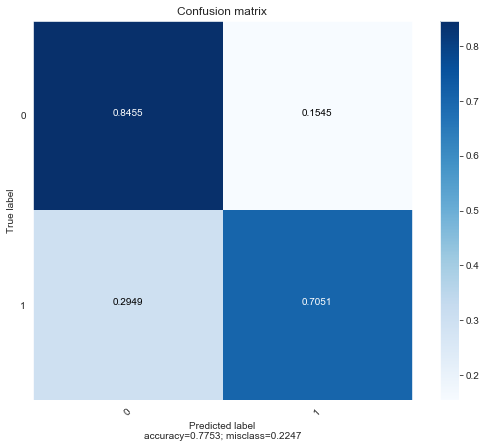

In [19]:
# dev[0]
ys, y_stars = net.get_eval_data(dev)
# confmat(ys, y_stars)
print('Dev F1: {}'.format(f1(ys, y_stars)))

twt['pred'] = pd.Series(y_stars, index = dev_idx)


# for error analysis
twt[['keyword', 'location', 'text', 'prepped','vec', 'target','pred']].to_csv('error_analysis.csv')

cm = confmat(ys, y_stars, normalize='true')
print(cm)
target_names = [0, 1]
plot_confusion_matrix(cm, target_names)

In [28]:
twt.iloc[twt.index == 982,]

,keyword,location,text,target,text+,text++,prepped,vec,pred
id,,,,,,,,,
982,blazing,"Pig Symbol, Alabama",Montgomery come for the blazing hot weather......,1,"Pig Symbol, Alabama Montgomery come for the bl...","blazing Pig Symbol, Alabama Montgomery come fo...","[montgomery, come, for, the, blazing, hot, wea...","[0.039899554, 0.026977539, 0.08116368, 0.07245...",0.0


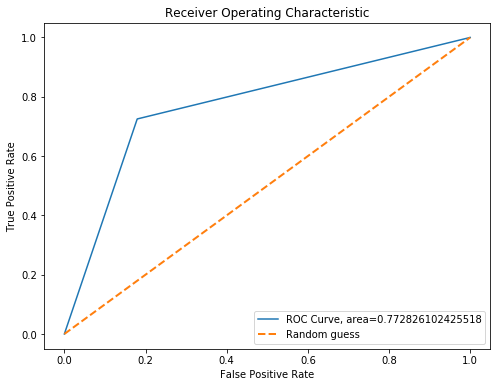

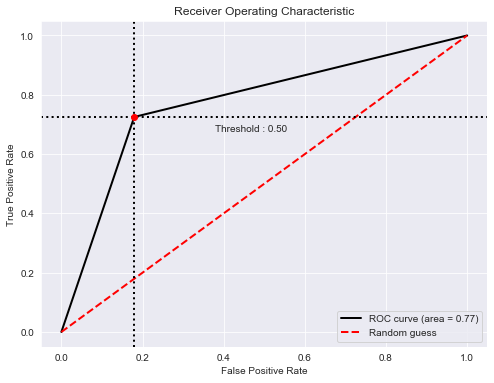

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from plot_metric.functions import BinaryClassification
# # ROC Curve - Style 1
fpr, tpr, _ = roc_curve(ys, y_stars)
auc = roc_auc_score(ys, y_stars)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label="ROC Curve, area="+str(auc))
plt.plot([0, 1], [0, 1], lw = 2, linestyle='--', label="Random guess")
plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


# ROC Curve - Style 2 (I think we chose this in the report)
# ROC Curve Visualisation with plot_metric
bc = BinaryClassification(ys, y_stars, labels=[0, 1])
# # Figures
plt.figure(figsize=(8,6))
bc.plot_roc_curve()
plt.show()

## Create Test Submissions

In [79]:
# create vector of mean of all word vectors
mean_vec = np.zeros((300,1))
for vec_targ in train:
    mean_vec = np.add(mean_vec, vec_targ[0])
mean_vec = mean_vec/len(train)

# read in test data and preprocess tweets
test = pd.read_csv('test.csv')
text = test['text']
proc_text = [preprocess.processing(i) for i in text]
targets = np.zeros((len(test), 1))
print('{} tweets read from test.csv'.format(test.shape[0]))


# test_data = [(tweet_vec(x, word2vec), y) if for x, y in zip(proc_test, targets)]
test['vec'] = pd.Series([preprocess.tweet_vec(tweet, word2vec) for tweet in proc_text], index = test.index)

print('{} tweets processed in the test set.'.format(test.shape[0]))

test_data = test['vec'].tolist()


_, y_stars = net.get_eval_data(test_data, mode = 'test')

# create columns for submission data
id = test['id'].to_numpy()
target = y_stars

# create df with submission data and write to csv
submission = pd.DataFrame({'id': id, 'target': target})
submission.set_index('id').to_csv('submission.csv')

# also save analysis csv for reviewing decisions
test['prepped'] = proc_text
test['pred'] = target
test[['keyword', 'location', 'text', 'prepped','pred']].to_csv('test_error_analysis.csv')

3263 tweets read from test.csv
3263 tweets processed in the test set.


In [43]:
test[['id', 'pred']].set_index('id').to_csv('submission.csv')

## 2. Naive Bayes with Bag of Words

In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

# create raw bow text and labels, shuffle
bow = twt['text'].to_numpy()
labels = twt['target'].to_numpy()

shuffle_idx = [x for x in range(len(bow))]
random.shuffle(shuffle_idx)

bow = bow[shuffle_idx]
labels = labels[shuffle_idx]

# train bag-of-words
count_vect = CountVectorizer()
x_bow = count_vect.fit(bow)

# create train dev split
train_bow = bow[:round(train_p*len(bow))]
dev_bow = bow[round(train_p*len(bow)):]
train_bow = count_vect.transform(train_bow)
dev_bow = count_vect.transform(dev_bow)

train_bow_labels = labels[:round(train_p*len(bow))]
dev_bow_lables = labels[round(train_p*len(bow)):]

print('Created {} bag-of-words vectorizations.'.format(train_bow.shape[0] + dev_bow.shape[0]))
clf = MultinomialNB().fit(train_bow, train_bow_labels)
print('Naive Bayes training complete.')

# get dev performances
ys = clf.predict(dev_bow)

# dev performance
print('Naive Bayes dev performance {}'.format(f1(ys, dev_bow_lables)))

Created 7613 bag-of-words vectorizations.
Naive Bayes training complete.
Naive Bayes dev performance 0.7500000000000001


## Missingness Exploration

We suspect that location data can be useful for predicting disasters. However, we have a sizable proportion of the data for which the location data is missing. In order to address this issue, we needed to first identify whether the data is missing completely at random, missing at random, or not missing at random. For the data to be MCAR, the mechanism of missingness of the data must be independent of all other observed features of the data. These other observed features, in our case, include the text of the tweet. Reviewing the Twitter policy on tweet-level location data, we found that twitter users must opt in to location services to embed location data in there tweets, as well as intentionally include location data on each desired tweet. This policy gives us an insight into some mechanisms of missingness - users forget that they can include location data, or the intentionally elect not to for some tweets. This second mechanism would preclude categorization as missing completely at random. Furthermore, as users of social media, the authors have firsthand experience with the relationship between the location from which a tweet was sent, and the inclusion of location data. Twitter users may want to inform followers that they are tweeting from an impressive or otherwise unusual location - a famous concert venue, or a historic city, or even the site of a terrible natural disaster - a decision surely not made at random. Being Missing Not a Random, our options for mitigating location data missingness are few. We could drop the data altogether, but decided that appending it to the contents of the tweet would be an acceptable approach that prevents information loss.


## Hyperparameter Tuning

### Hidden Layers and Preprocessing

In [85]:
# hidden Layer dimensions
pre_opts = [(1, 0, 0), (1, 1, 0), (1, 0, 1) , (1, 1, 1), (0, 1, 0), (0, 1, 1), (0, 0, 1)]
Fs_ls = []
for column in ['text', 'text+', 'text++']:
    text = twt[column]
    for lower, stopwords, stem in pre_opts:
        prep_text = [preprocess.processing(i, lower, stopwords, stem) for i in text]
        # print('{} tweets lowered, tokenized, alphanumerized, stop-stripped, and stemmed.'.format(len(prep_text)))

        twt['vec'] = pd.Series([preprocess.tweet_vec(tweet, word2vec) for tweet in prep_text], index = twt.index)

        devtrain_idx = twt.loc[~twt['vec'].isna()].index.tolist()
        random.shuffle(devtrain_idx)

        train_p = 0.7
        train_idx = devtrain_idx[:round(train_p*len(devtrain_idx))]
        dev_idx = devtrain_idx[round(train_p*len(devtrain_idx)):]

        train = [(vec, targ) for targ, vec in  zip(twt['target'][train_idx], twt['vec'][train_idx])]
        dev = [(vec, targ) for targ, vec in  zip(twt['target'][dev_idx], twt['vec'][dev_idx])]

        Fs = []
        for hiddenDim in range(2,150,10):
            # print('Executing model with hidden layer dimensionality {}'.format(hiddenDim))
            net = dan.Net(hiddenDim)
            net.train(train, dev, verbose = False)
            ys, y_stars = net.get_eval_data(dev)
            Fs.append(f1(ys, y_stars))
            print('Finished training')
        Fs_ls.append(Fs)

results = {i : Fs_ls[i] for i in range(len(Fs_ls))}
pd.DataFrame(results).to_csv('hiddenDim_preprocessing.csv')

Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished training
Finished t

KeyboardInterrupt: 

### Size and Class Balance of Training Data

In [25]:
samples = [pd.concat([twt, add.sample(n = N)], axis = 0) for N in [0, 2000, 5000, 10000, 15000]]

Fs_ls  = []
FPR_ls = []
for sample in samples:
    text = sample['text']
    prep_text = [preprocess.processing(i) for i in text]
    # print('{} tweets lowered, tokenized, alphanumerized, stop-stripped, and stemmed.'.format(len(prep_text)))

    sample['vec'] = pd.Series([preprocess.tweet_vec(tweet, word2vec) for tweet in prep_text], index = sample.index)

    devtrain_idx = sample.loc[~sample['vec'].isna()].index.tolist()
    random.shuffle(devtrain_idx)

    train_p = 0.7
    train_idx = devtrain_idx[:round(train_p*len(devtrain_idx))]
    dev_idx = devtrain_idx[round(train_p*len(devtrain_idx)):]

    train = [(vec, targ) for targ, vec in  zip(sample['target'][train_idx], sample['vec'][train_idx])]
    dev = [(vec, targ) for targ, vec in  zip(sample['target'][dev_idx], sample['vec'][dev_idx])]

    Fs = []
    FPR = []
    for hiddenDim in range(2,302,25):
        # print('Executing model with hidden layer dimensionality {}'.format(hiddenDim))
        net = dan.Net(hiddenDim)
        net.train(train, dev, verbose = False)
        ys, y_stars = net.get_eval_data(dev)
        Fs.append(f1(ys, y_stars))
        # false positive rate
        FPR.append(np.sum([1 if (y == 0) and (y_star == 1) else 0 for y, y_star in zip(ys, y_stars)])/(len(ys) - np.sum(ys)))
    Fs_ls.append(Fs)
    FPR_ls.append(FPR)

f1_results = {i : Fs_ls[i] for i in range(len(Fs_ls))}
fpr_results = {i : FPR_ls[i] for i in range(len(FPR_ls))}
pd.DataFrame(fpr_results).to_csv('data_dim_ablation_fpr.csv')

Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Training.
Finished Tra

## Learning Rate, Epochs and Optimizer

In [29]:
import importlib
importlib.reload(dan)
Fs_ls  = []
text = twt['text']
prep_text = [preprocess.processing(i) for i in text]
# print('{} tweets lowered, tokenized, alphanumerized, stop-stripped, and stemmed.'.format(len(prep_text)))

twt['vec'] = pd.Series([preprocess.tweet_vec(tweet, word2vec) for tweet in prep_text], index = twt.index)

devtrain_idx = twt.loc[~twt['vec'].isna()].index.tolist()
random.shuffle(devtrain_idx)

train_p = 0.7
train_idx = devtrain_idx[:round(train_p*len(devtrain_idx))]
dev_idx = devtrain_idx[round(train_p*len(devtrain_idx)):]

train = [(vec, targ) for targ, vec in  zip(sample['target'][train_idx], sample['vec'][train_idx])]
dev = [(vec, targ) for targ, vec in  zip(sample['target'][dev_idx], sample['vec'][dev_idx])]

Fs = []
for opter in ['adam', 'sgd']:
    # print('Executing model with hidden layer dimensionality {}'.format(hiddenDim))
    for epochs in [5, 10, 50, 100]:
        Fs = []
        for lr in np.logspace(-4, -1, 7):
            net = dan.Net(hiddenDim)
            net.train(train, dev, verbose = False, opter = opter, lr = lr, epochs = epochs)
            ys, y_stars = net.get_eval_data(dev)
            Fs.append(f1(ys, y_stars))
            # false positive rate
        Fs_ls.append(Fs)

f1_results = {i : Fs_ls[i] for i in range(len(Fs_ls))}
pd.DataFrame(f1_results).to_csv('epochs_lr_opter_ablation.csv')